In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
%matplotlib inline

In [2]:
# Read the dataset into a data frame
df = pd.read_excel('nyc_crime2013.xls', skiprows=4)
df.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object')

In [3]:
# Create a data frame with only the features of interest
pc_df = df[['City', 'Population', 'Murder and\nnonnegligent\nmanslaughter', 'Robbery', 'Property\ncrime']].copy()
murder = 'Murder and\nnonnegligent\nmanslaughter'
p_crime = 'Property\ncrime'
pc_df.head()

,City,Population,Murder and nonnegligent manslaughter,Robbery,Property crime
0,Adams Village,1861.0,0.0,0.0,12.0
1,Addison Town and Village,2577.0,0.0,0.0,24.0
2,Akron Village,2846.0,0.0,0.0,16.0
3,Albany,97956.0,8.0,227.0,4090.0
4,Albion Village,6388.0,0.0,4.0,223.0


In [4]:
# Determine if there are null values
pc_df.isna().sum()

City                                      0
Population                                3
Murder and\nnonnegligent\nmanslaughter    3
Robbery                                   3
Property\ncrime                           3
dtype: int64

In [5]:
# Drop the information rows at the end of the dataset
pc_df.dropna(how='any', inplace=True)
pc_df.describe()

,Population,Murder and nonnegligent manslaughter,Robbery,Property crime
count,3.480000e+02,348.000000,348.000000,348.000000
mean,4.003763e+04,1.566092,72.902299,792.606322
std,4.500374e+05,18.303673,1031.032873,7659.724746
min,5.260000e+02,0.000000,0.000000,0.000000
25%,3.003000e+03,0.000000,0.000000,40.500000
50%,7.233500e+03,0.000000,1.000000,112.500000
75%,1.842750e+04,0.000000,5.000000,341.000000
max,8.396126e+06,335.000000,19170.000000,141971.000000


In [6]:
# Find the amomalous robbery cities
robbery_anomaly = pc_df['Robbery'].mean() + (2 * np.std(pc_df['Robbery'])) 
pc_df.loc[pc_df['Robbery'] > robbery_anomaly]

,City,Population,Murder and nonnegligent manslaughter,Robbery,Property crime
216,New York,8396126.0,335.0,19170.0,141971.0


In [7]:
# Find the anomalous murder cities
m_anomaly = pc_df[murder].mean() + (2 * np.std(pc_df[murder])) 
big_cities = pc_df.loc[pc_df[murder] > m_anomaly]

In [8]:
# Drop the anomalous big cities because of the outsized effect they would have on the model
# These big cities might be better suited with a comparison of other large urban areas across the nation
pc_df.drop(big_cities.index, inplace=True)
pc_df.describe()

,Population,Murder and nonnegligent manslaughter,Robbery,Property crime
count,345.000000,345.000000,345.000000,345.000000
mean,14688.750725,0.350725,11.478261,322.649275
std,21318.571420,1.587160,41.615561,612.050221
min,526.000000,0.000000,0.000000,0.000000
25%,2985.000000,0.000000,0.000000,39.000000
50%,7112.000000,0.000000,1.000000,112.000000
75%,17965.000000,0.000000,5.000000,337.000000
max,199134.000000,21.000000,400.000000,6473.000000


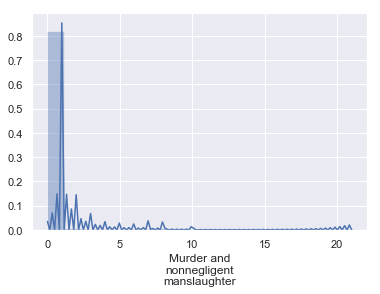

In [9]:
# Check the distribution  of Murder
sns.set()
sns.distplot(pc_df[murder])
plt.show()

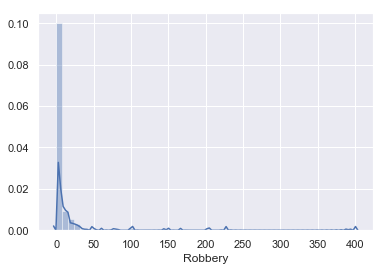

In [10]:
# Check the distribution of Robbery
sns.distplot(pc_df['Robbery'])
plt.show()

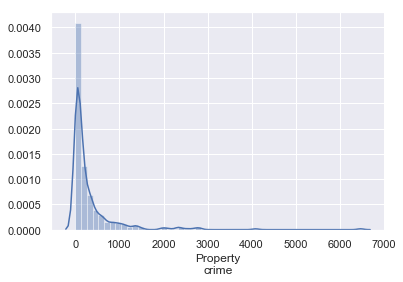

In [11]:
# Check the distribution of property crime
sns.distplot(pc_df[p_crime])
plt.show()

In [12]:
#Create features for population squared and for the categorical versions murder and robbery
pc_df['Pop^2'] = pc_df['Population'].apply(lambda x: x**2)
pc_df[[murder, 'Robbery']] = pc_df[[murder, 'Robbery']].applymap(lambda x: 1 if x>0 else 0)
pc_df.head()

,City,Population,Murder and nonnegligent manslaughter,Robbery,Property crime,Pop^2
0,Adams Village,1861.0,0,0,12.0,3.463321e+06
1,Addison Town and Village,2577.0,0,0,24.0,6.640929e+06
2,Akron Village,2846.0,0,0,16.0,8.099716e+06
3,Albany,97956.0,1,1,4090.0,9.595378e+09
4,Albion Village,6388.0,0,1,223.0,4.080654e+07
